In [1013]:
import pandas as pd
import geopandas as gpd
import datetime as dt
import numpy as np
import math
from scipy.optimize import minimize, Bounds
from scipy.stats import norm
from haversine import haversine
from scipy.spatial.distance import euclidean
from shapely.geometry import Polygon, MultiPolygon
from matplotlib import pyplot as plt, ticker

## Obtenção e preparo da amostra

In [912]:
entregas = pd.read_csv('Dados/New_query_2023_07_15.csv', parse_dates=['event_day', 'event_timestamp', 'event_timestamp_hour']).sort_values('event_timestamp')

In [913]:
entregas_por_rest = entregas.groupby('frn_id')['order_id'].nunique().reset_index()

In [930]:
tamanho_amostra = len(entregas_por_rest)

In [932]:
rests_amostra = entregas_por_rest[entregas_por_rest.order_id > 0][['frn_id']].drop_duplicates().sample(n=tamanho_amostra, random_state=123)

In [933]:
entregas_amostra = entregas.merge(rests_amostra, on='frn_id')

In [934]:
inicio_fim_rotas = entregas_amostra.groupby('route_id', as_index=False).agg({'event_timestamp': ['min', 'max']}).droplevel(0, 1).rename({'': 'route_id', 'min': 'inicio_rota', 'max': 'fim_rota'}, axis='columns')

In [935]:
entregas_amostra = entregas_amostra.merge(inicio_fim_rotas, how='inner', on='route_id')

## Funções Processo Espacial de Nascimento e Morte

In [936]:
def montar_janela(t0, m, delta_t):
    """
    Obtém uma janela de m datetimes iniciando em t0 e saltando a cada delta_t
    
    :param t0: momento inicial da janela
    :param m: número de momentos que compõem a janela
    :param delta_t: tamanho do salto de tempo entre cada momento t
    :returns: uma lista de momentos compondo uma janela
    """
    return [t0 + dt.timedelta(minutes=m) for m in range(0, m * delta_t, delta_t)]

In [966]:
def configurar_janela(df, evt, fim, obj, lat, lng, t0, m, delta_t):
    """
    Obtém a configuração de estado de cada momento de uma janela
    
    :param df: dataframe com os dados para popular a janela
    :param evt: coluna com as atualizações de cada evento
    :param fim: coluna com o término de cada evento
    :param obj: coluna com o objeto que nasce/morre/move
    :param lat: coluna com as latitudes do evento
    :param lng: coluna com as longitudes do evento
    :param t0: momento inicial da janela
    :param m: número de momentos que compõem a janela
    :param delta_t: tamanho do salto de tempo entre cada momento t
    :returns: uma janela com suas configurações em cada momento t
    """
    j = montar_janela(t0, m, delta_t)
    X = []

    for t in j:
        objs_vivos = df[(df[evt] <= t) & (df[fim] > t)]
        ids = objs_vivos[obj].unique()
        coords = objs_vivos.drop_duplicates(subset=[obj], keep='last')[[lat, lng]].to_numpy()
        X.append({'t': t, 'n': len(coords), 'id': ids, 'xy': coords})
        
    return X

In [1091]:
def hausdorff(janela, chave_t, chave_xy, dist_fn):
    matriz_hausdorff = []

    for i, Ji in enumerate(janela):
        linha = []
        for j, Jj in enumerate(janela):
            if i < j:
                matriz_dist = np.array([np.array([dist_fn(k, l) for l in Jj[chave_xy]]) for k in Ji[chave_xy]])
                dist = np.max(np.concatenate((np.amin(matriz_dist, axis=1), np.amin(np.transpose(matriz_dist), axis=1))))
            elif i > j:
                dist = matriz_hausdorff[j][i]
            else:
                dist = 0

            linha.append(dist)
        matriz_hausdorff.append(np.array(linha))
    matriz_hausdorff = np.array(matriz_hausdorff)

    return matriz_hausdorff

In [951]:
def estimador_alfa(delta_n, delta_t, h, matriz_dist,K=norm.pdf):
    Kt = K(matriz_dist, 0, h).flatten()
    n = len(Kt) - 1
    Kt = np.delete(Kt, [n])
    t_chapeu = sum(Kt * delta_t)

    return np.sum(np.divide(np.resize(delta_n, n) * Kt, t_chapeu, where=t_chapeu != 0))

In [1100]:
def log_verossimilhanca(h, janela, delta_n, delta_t, matriz_dist, K=norm.pdf):
    n = len(janela) - 1
    alfa_i = []
    
    for i in range(n):
        saltos_t = np.delete(delta_n, [i])
        dists_t = np.delete(matriz_dist[i], [i])
        alfa_i.append(estimador_alfa(saltos_t, delta_t, h, dists_t, K=K))
    print(h)
    return -np.sum(delta_n * np.log(alfa_i)) + np.sum(delta_t * alfa_i)

In [ ]:
janela = configurar_janela(entregas_amostra, 'event_timestamp', 'fim_rota', 'driver_uuid', 'drv_lat', 'drv_lng', dt.datetime(2023, 1, 10, 0, 15, 0, 0), 95, 15)
matriz_dists = hausdorff(janela, 't', 'xy', haversine)
beta = [len(np.setdiff1d(j['id'], i['id'])) for (i, j) in zip(janela[:-1] , janela[1:])]
log_verossimilhanca(1.001e-05, janela, beta, 15, matriz_dists)

In [1101]:
def maximizar_verossimilhanca(janela, delta_n, delta_t, matriz_dist, K=norm.pdf):
    iniciar = np.quantile(matriz_dist, 0.1) / 2
    maximo = np.max(matriz_dist)
    
    return minimize(fun=log_verossimilhanca, x0=(iniciar,), args=(janela, delta_n, delta_t, matriz_dist, K), bounds=Bounds(0.00001, maximo)).x

## Gerador dos estimadores

In [1106]:
jan_teste = [
    {'t': dt.datetime(2023, 1, 10, 0, 15), 'xy': np.array([[29.30464, 129.0295], [175.52776, 85.88214]])},
    {'t': dt.datetime(2023, 1, 10, 0, 30), 'xy': np.array([[29.1836, 129.0577], [175.7906, 86.25676], [107.1100, 176.47044]])}
]

hausdorff(jan_teste, 't', 'xy', euclidean)

array([[ 0.        , 91.12802441],
       [91.12802441,  0.        ]])

In [1102]:
def gerar_estimadores(df, evt, fim, obj, lat, lng, ini_janela, m, delta_t):
    janela = configurar_janela(df, evt, fim, obj, lat, lng, ini_janela, m, delta_t)
    matriz_dists = hausdorff(janela, 't', 'xy', haversine)
    beta = [len(np.setdiff1d(j['id'], i['id'])) for (i, j) in zip(janela[:-1] , janela[1:])]
    delta = [len(np.setdiff1d(i['id'], j['id'])) for (i, j) in zip(janela[:-1] , janela[1:])]
    h_chapeu_beta = maximizar_verossimilhanca(janela, beta, delta_t, matriz_dists)
    beta_chapeu = [estimador_alfa(beta, delta_t, h_chapeu_beta, l) for l in matriz_dists]
    h_chapeu_delta = maximizar_verossimilhanca(janela, delta, delta_t, matriz_dists)
    delta_chapeu = [estimador_alfa(delta, delta_t, h_chapeu_delta, l) for l in matriz_dists]
    
    return {'h_chapeu_b': h_chapeu_beta,
            'b': beta,
            'b_chapeu': beta_chapeu,
            'h_chapeu_d': h_chapeu_delta,
            'd': delta,
            'd_chapeu': delta_chapeu}

In [1103]:
estimadores = gerar_estimadores(entregas_amostra, 'event_timestamp', 'fim_rota', 'driver_uuid', 'drv_lat', 'drv_lng', dt.datetime(2023, 1, 10, 0, 15, 0, 0), 95, 15)

[1.83741503]
[1.83741504]
[1.e-05]
[1.001e-05]
[1.83741503]
[1.83741504]
[1.83741503]
[1.83741504]
[1.e-05]
[1.001e-05]


C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_5136\1839392755.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.sum(delta_n * np.log(alfa_i)) + np.sum(delta_t * alfa_i)
C:\Users\souza.daniel_ifood\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\souza.daniel_ifood\AppData\Local\Temp\ipykernel_5136\1839392755.py:10: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(delta_n * np.log(alfa_i)) + np.sum(delta_t * alfa_i)


## Gradeamento da área da cidade

In [987]:
fortaleza = gpd.read_file('Dados/Densidade_Populacional_por_Bairros.zip')

In [988]:
def arred_baixo(num, dec):
    return math.floor(num * 10 ** dec) / 10 ** dec

In [989]:
def criar_celula(lat, lng, passo):
    return Polygon([(lat, lng), (lat + passo, lng), (lat + passo, lng + passo), (lat, lng + passo)])

In [990]:
x_min, y_min, x_max, y_max = (arred_baixo(b, 2) for b in fortaleza.geometry.unary_union.bounds)

In [991]:
p = 0.01

In [992]:
grade_completa = MultiPolygon((criar_celula(x, y, p) for x in np.arange(x_min - p, x_max + p, p) for y in np.arange(y_min - p, y_max + p, p)))   

In [993]:
grade_fortaleza = MultiPolygon([c for c in grade_completa.geoms if c.intersects(fortaleza.unary_union)])

<AxesSubplot:>

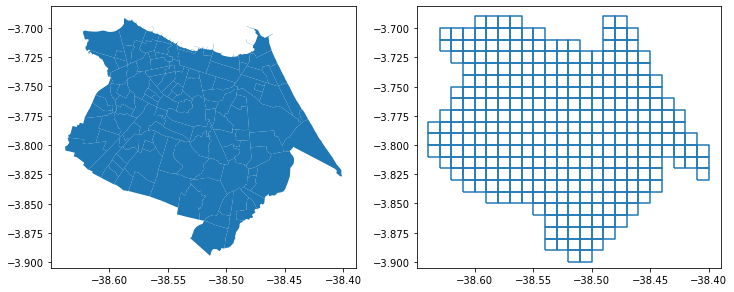

In [994]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fortaleza.plot(ax=ax1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
gpd.GeoSeries(grade_fortaleza).boundary.plot(ax=ax2)

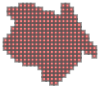

In [998]:
grade_fortaleza

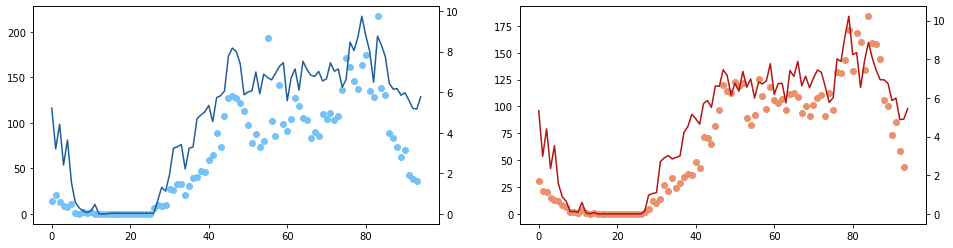

In [1104]:
fig, (axn, axd) = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))

axn.scatter(range(len(estimadores['b'])), estimadores['b'], color='#75C2F6', label='emp')
axn_2 = axn.twinx()
axn_2.plot(range(len(estimadores['b_chapeu'])), estimadores['b_chapeu'], color='#1D5D9B', label='est')

axd.scatter(range(len(estimadores['d'])), estimadores['d'], color='#EA906C', label='emp')
axd_2 = axd.twinx()
axd_2.plot(range(len(estimadores['d_chapeu'])), estimadores['d_chapeu'], color='#B31312', label='est')